"https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification" adlı veri seti kullanılarak bbc metinlerinde sınıflandırma yapıldı. Bu sınıflandırma çalışması için BERT finetune edildi.

In [84]:
import pandas as pd

In [85]:
df=pd.read_csv("/content/bbc_data.csv")
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [87]:
df["labels"].value_counts()

,count
labels,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [88]:
target_count = 386

# Sınıfları gruplama
grouped = df.groupby("labels")

# Undersampling
df_undersampled = grouped.apply(lambda x: x.sample(n=target_count, random_state=42)).reset_index(drop=True)

print(df_undersampled["labels"].value_counts())  # Her sınıfta 386 veri olduğunu kontrol edin


labels
business         386
entertainment    386
politics         386
sport            386
tech             386
Name: count, dtype: int64


<ipython-input-88-a79a553697e7>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_undersampled = grouped.apply(lambda x: x.sample(n=target_count, random_state=42)).reset_index(drop=True)


In [89]:
df_undersampled.head()

,data,labels
0,Ericsson sees earnings improve Telecoms equip...,business
1,Kraft cuts snack ads for children Kraft plans...,business
2,Worldcom boss left books alone Former Worldco...,business
3,Steady job growth continues in US The US crea...,business
4,Boeing unveils new 777 aircraft US aircraft f...,business


In [90]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_undersampled['labels'] = label_encoder.fit_transform(df_undersampled['labels'])


In [91]:
df_undersampled.head()

,data,labels
0,Ericsson sees earnings improve Telecoms equip...,0
1,Kraft cuts snack ads for children Kraft plans...,0
2,Worldcom boss left books alone Former Worldco...,0
3,Steady job growth continues in US The US crea...,0
4,Boeing unveils new 777 aircraft US aircraft f...,0


In [94]:
df_undersampled["labels"].unique()

array([0, 1, 2, 3, 4])

In [95]:
#id2label ve label2id diye iki tane dictionary oluşturmamız lazım.
id2label={0:"businees",1:"entertainment",2:"politics",3:"sport",4:"tech"}
label2id={"businees":0,"entertainment":1,"politics":2,"sport":3,"tech":4}

In [96]:
##bert ile finetune ederek sınıflandırma yapacağım. sequence snııflandırma
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=5, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
from torch.utils.data import DataLoader,Dataset


class CustomDataset(Dataset):
    def __init__(self, dataframe,tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Girdi ve etiket sütunlarını ayır
        input_data = self.dataframe.iloc[idx, 0]  # İlk sütun
        labels = torch.tensor(self.dataframe.iloc[idx, 1])


        encoded_text = self.tokenizer(input_data,
                                      max_length=64,
                                      padding='max_length',
                                      truncation=True
                                       )

        input_ids = torch.tensor(encoded_text['input_ids'])
        attention_masks = torch.tensor(encoded_text['attention_mask'])
        return input_ids,attention_masks,labels




In [118]:
##şimdi dataset ve dataloader yapıcaz.
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df_undersampled,test_size=0.2,random_state=42)


train_data=CustomDataset(train_df,tokenizer)
test_data=CustomDataset(test_df,tokenizer)

train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False)



In [119]:
from torch.optim import AdamW
import torch.nn as nn

In [120]:

optimizer=AdamW(params=model.parameters(),lr=1e-5)

In [123]:
num_epoch=4
train_loss,val_loss=[],[]
for epoch in range(num_epoch):
  model.train()
  running_loss=0.0
  for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    output=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
    loss=output.loss
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    train_loss.append(running_loss)

Accuracy: 0.9741
Precision: 0.9741
Recall: 0.9741
F1 Score: 0.9740


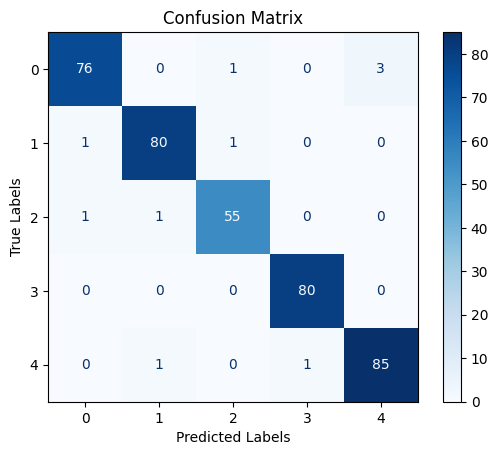

In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt


# Modeli evaluation moduna geçir
model.eval()

all_preds = []
all_labels = []

# Test verisi üzerinde değerlendirme
with torch.no_grad():
    for input_ids, attention_masks, labels in test_loader:


        # Modelden tahminler al
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performans metriklerini hesapla
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix çizimi
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()

In [132]:
def predict_sentence(model, sentence):
    # Cümleyi token'lara dönüştür ve tensör haline getir
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Modelden tahmin al
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    return preds.cpu().item()  # Tek bir tahmin döndüğü için item() kullanıyoruz



In [139]:
# Test cümlesi
sentence = "The latest smartphone features cutting-edge AI technology for enhanced user experience."
predicted_label = predict_sentence(model, sentence)
print(model.config.id2label[predicted_label])

tech
